In [3]:
import skfem
import meshio
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pandas as pd
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace, mass
from skfem.helpers import grad, dot, laplacian

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg
import pandas as pd


In [18]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u, scale = 20):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=scale, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

### U refinado

In [10]:
eig_u = pd.read_csv('eigenfunctions/velocity_eigenfunctions_u_refinado.csv')
eig_p = pd.read_csv('eigenfunctions/pressure_eigenfunctions_u_refinado.csv')

In [11]:
f = h5py.File('umesh_h3.h5', 'r')
coordinates_mesh = f['mesh/coordinates'][:]
elements_mesh    = f['mesh/topology'][:]
mesh = MeshTri(coordinates_mesh.T, elements_mesh.T)

# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


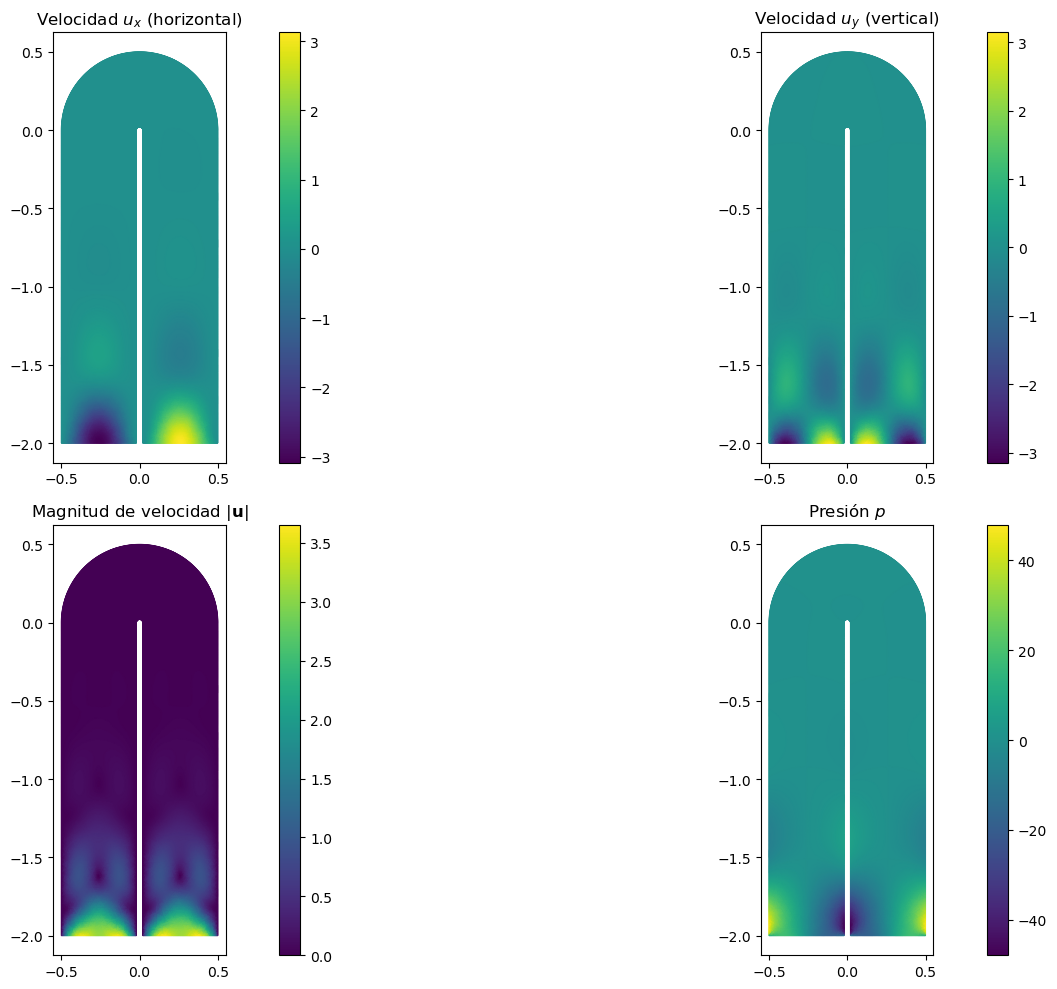

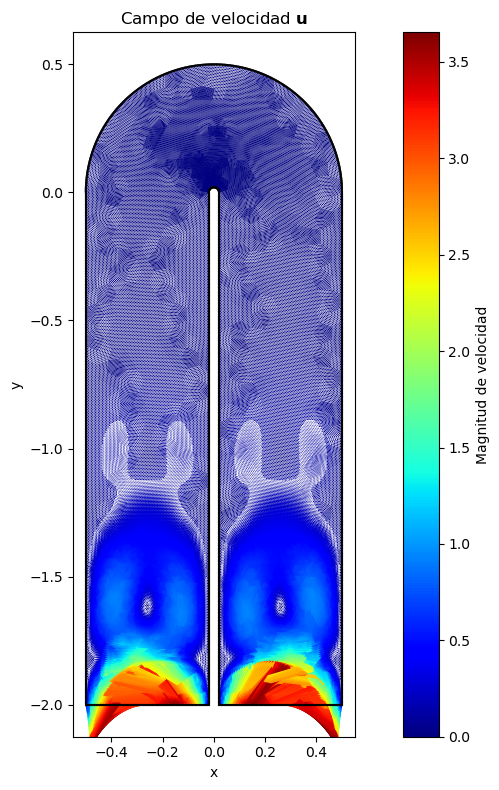

In [12]:
graficar_stokes(eig_u.iloc[:,1].values, eig_p.iloc[:,1].values, mesh, basis_p, basis_u)

### Arterias

In [13]:
eig_u = pd.read_csv('eigenfunctions/velocity_eigenfunctions_arterias.csv')
eig_p = pd.read_csv('eigenfunctions/pressure_eigenfunctions_arterias.csv')

In [16]:
f = h5py.File('Carotid_h1.h5', 'r')
coordinates_mesh = f['mesh/coordinates'][:]
elements_mesh    = f['mesh/topology'][:]
mesh = MeshTri(coordinates_mesh.T, elements_mesh.T)

# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


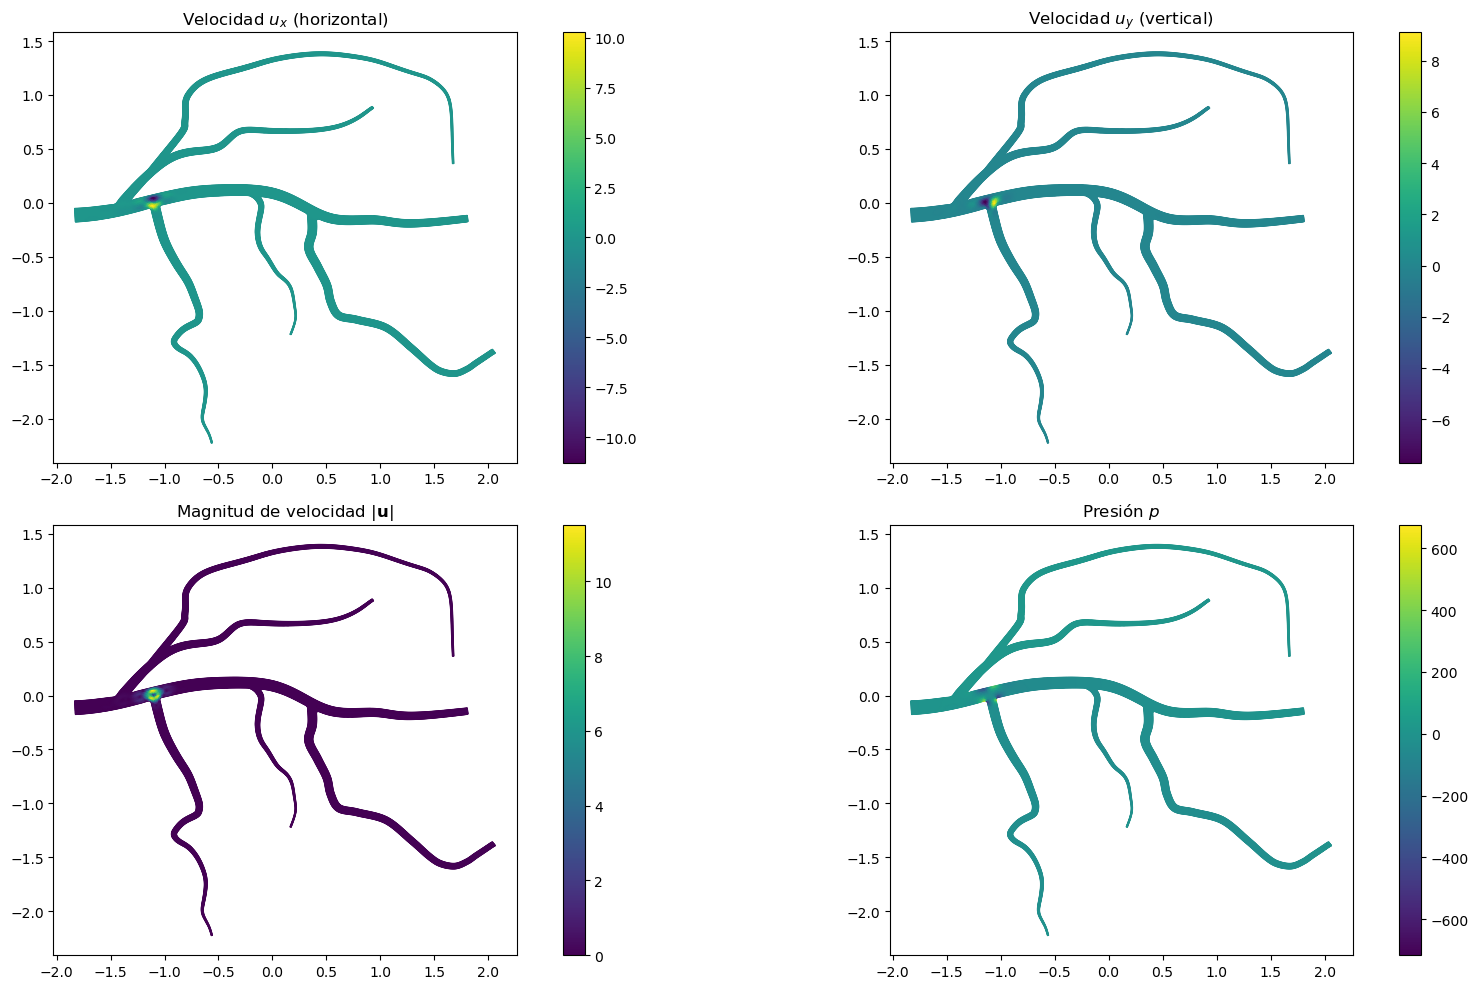

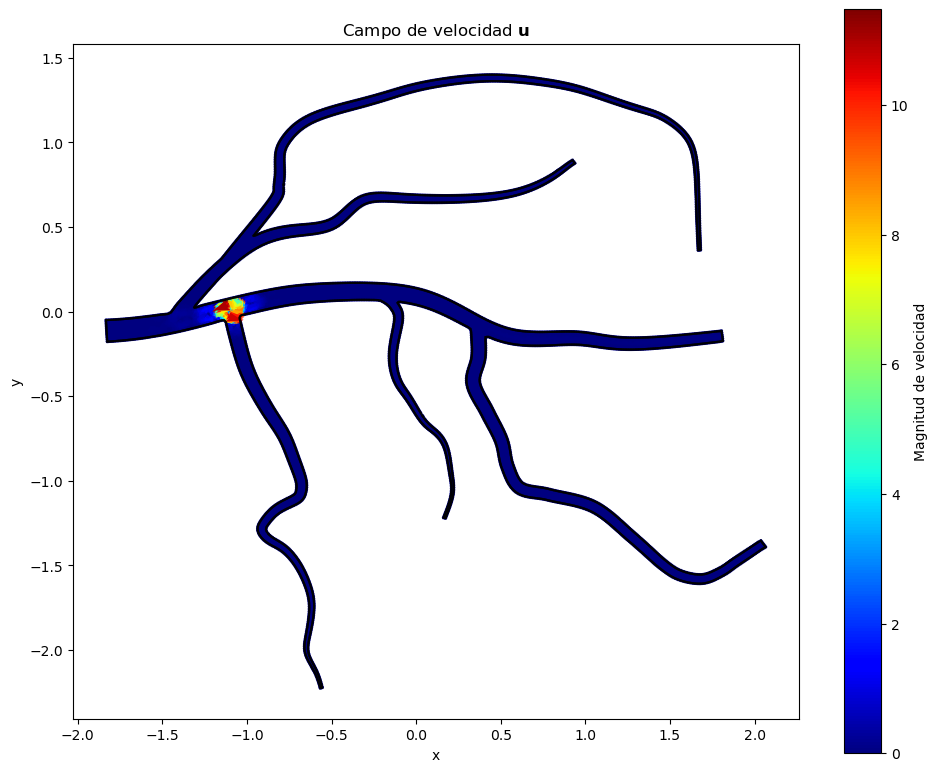

In [24]:
graficar_stokes(eig_u.iloc[:,3].values, eig_p.iloc[:,3].values, mesh, basis_p, basis_u, scale=500)